In [1]:
import imnn
import imnn.lfi
from imnn.utils import value_and_jacrev, value_and_jacfwd

import jax
import jax.numpy as jnp

import jraph

import matplotlib.pyplot as plt

In [2]:
from struct import unpack

# void read script

# load in data

In [3]:
maindir = '/data80/makinen/quijote/Voids/'

In [10]:
import h5py

f = h5py.File('/data80/makinen/quijote/Voids/s8_m/50/void_catalogue_m_z=0.hdf5', 'r')
pos        = f['pos'][:]        #void center positions in Mpc/h
radius     = f['radius'][:]     #void radii in Mpc/h
VSF        = f['VSF'][:]        #VSF (#voids/dR/Volume)
VSF_Rbins  = f['VSF_Rbins'][:]  #VSF radii in Mpc/h
parameters = f['parameters'][:] #parameters used to run the void finder
f.close()

In [11]:
parameters

array([b'768', b'PCS', b'[1]', b'-0.5',
       b'[ 53.38541794  50.78125     48.17708206  45.57291794  42.96875     40.36458206\n  37.76041794  35.15625     32.55208206  29.94791603  27.34375     24.73958397\n  22.13541603  19.53125     16.92708397  14.32291698  11.71875      9.11458302\n   6.51041651]'],
      dtype='|S251')

In [6]:
radius[radius > 30].max()

48.177086

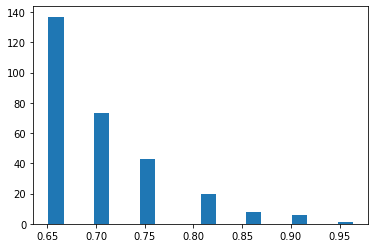

In [7]:
plt.hist(radius[radius > 30] / 50, bins=20)
plt.show()

In [8]:
np = jnp

In [9]:
from functools import partial

# helper functions
def get_distances(X):
    nx = X.shape[0]
    return (X[:, None, :] - X[None, :, :])[jnp.tril_indices(nx, k=-1)]


def get_receivers_senders(nx, dists, connect_radius=100):
    '''connect nodes within `connect_radius` units'''
    
    senders,receivers = jnp.tril_indices(nx, k=-1)
    mask = dists < connect_radius
    return senders[mask], receivers[mask]

def get_r2(X):
    nx = X.shape[0]
    # can also do
    #a = X
    #b = a.reshape(a.shape[0], 1, a.shape[1])
    # jnp.sqrt(jnp.einsum('ijk, ijk->ij', a-b, a-b))
    alldists = jnp.linalg.norm(X[:, None, :] - X[None, :, :], axis=-1)
    return alldists[jnp.tril_indices(nx, k=-1)]

#@partial(jax.jit, static_argnums=3)
def numpy_to_graph(X, radii, 
                   connect_radius=50, 
                   return_components=True,
                   scale_inputs=True, 
                   nx=None):
    if nx is None:
        nx = jnp.array([X.shape[0]])
        
    _nx = jnp.array([nx])
    
    radii = jnp.array(radii)
    
    if scale_inputs:
        X /= 1000. # in units of Gpc
        connect_radius /= 1000. # in units of Gpc
        radii /= 50.
        
    
    # mask out halos with distances < connect_radius
    dists = get_r2(X)
    
    receivers, senders = get_receivers_senders(nx, dists, 
                                               connect_radius=connect_radius)
    
    edges = dists[dists < connect_radius]

    receivers = jnp.array(receivers)
    senders = jnp.array(senders)



    nodes = jnp.concatenate([radii.reshape([-1, 1]), X], axis=1)
    
    if return_components:
        return nodes,senders,receivers,edges[:, None], nx, jnp.array(edges.shape[0])
    
    else:
        graph = jraph.GraphsTuple(nodes=nodes, senders=senders, receivers=receivers,
                                  edges=edges[:, None], n_node=_nx, n_edge=jnp.array([edges.shape[0]]), globals=None)
        return graph



def update_edge_dummy(edge, sender_node, receiver_node, globals_):
    return edge


def update_node_dummy(node, sender, receiver, globals_):
    return node


In [10]:
radius_cut = (radius > 30)
print(jnp.sum(radius_cut))

288


In [11]:
# do for small test data
%time
radius_cut = (radius > 40)
print(jnp.sum(radius_cut))

X = pos[radius_cut]
myradii = radius[radius_cut]


# mask out halos with distances < 50 Mpc
connect_radius = 500 # Mpc
dists = np.abs(get_distances(X))

graph = numpy_to_graph(X, myradii, return_components=False, connect_radius=connect_radius)

CPU times: user 0 ns, sys: 28 µs, total: 28 µs
Wall time: 56.3 µs
35


In [110]:
graph.nodes.shape

(35, 4)

In [111]:
graph.senders.shape

(160,)

In [112]:
graph.edges.shape

(160, 1)

# make a function to pull in a bunch of datasets

In [12]:
maindir

'/data80/makinen/quijote/Voids/'

In [13]:
def load_single_sim(folder_name, 
             sim_num,
             radius_cut=40,
             snapnum=4):
    
    # determine the redshift of the catalogue
    z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
    redshift = z_dict[snapnum]
    
    
    f = h5py.File(folder_name + '/%d/void_catalogue_m_z=%d.hdf5'%(sim_num, redshift), 'r')
    pos        = f['pos'][:]        #void center positions in Mpc/h
    radius     = f['radius'][:]     #void radii in Mpc/h
    VSF        = f['VSF'][:]        #VSF (#voids/dR/Volume)
    VSF_Rbins  = f['VSF_Rbins'][:]  #VSF radii in Mpc/h
    parameters = f['parameters'][:] #parameters used to run the void finder
    f.close()
    
    radius_cut = (radius > radius_cut)
    
    return radius[radius_cut], pos[radius_cut]

In [115]:
graph.nodes.shape

(35, 4)

In [14]:
def get_halo_batch(folder_name, 
                  sim_index,
                  pad_nodes_to=150,
                  pad_edges_to=200,
                  radius_cut=40, 
                  connect_radius=500,
                  node_features=4,
                  edge_features=1):

    n_sims = len(sim_index)
    
    
    # padding for vmapping
    def get_padding(pad_nodes_to, pad_edges_to):
        nodes =  jnp.zeros((n_sims, pad_nodes_to, node_features))
        senders = jnp.zeros((n_sims, pad_edges_to), dtype=int) 
        receivers = jnp.zeros((n_sims, pad_edges_to), dtype=int)
        edges = jnp.zeros((n_sims, pad_edges_to, edge_features))
        n_node = []
        n_edge = []
        _globals = None
        return nodes,senders,receivers,edges,n_node,n_edge,_globals
    
    nodes,senders,receivers,edges,n_node,n_edge,_globals = get_padding(pad_nodes_to,pad_edges_to)
    l = 0
    
    while l < len(sim_index):
        
        i = sim_index[l]
        
        radii,X = load_single_sim(folder_name, i, radius_cut)
        _nodes,_senders,_receivers,_edges, _nx, _n_edge = numpy_to_graph(X, radii, 
                                                       return_components=True,
                                                       connect_radius=connect_radius)
        
        if _nx < pad_nodes_to:
            if _n_edge < pad_edges_to:
                nodes = nodes.at[l, :_nodes.shape[0], :].set(_nodes)
                senders = senders.at[l, :_senders.shape[0]].set(_senders)
                receivers = receivers.at[l, :_receivers.shape[0]].set(_receivers)

                edges = edges.at[l, :_edges.shape[0], :].set(_edges)

                n_node.append(_nx) # these control how many edges / nodes get counted
                n_edge.append(_n_edge)
                l += 1

            else:
                print('boosting edge padding; \n restarting batch loop...')
                pad_edges_to += 10
                print('new edge padding length:', pad_edges_to)
                nodes,senders,receivers,edges,n_node,n_edge,_globals = get_padding(pad_nodes_to,pad_edges_to)
                l = 0 

        else:
            print('boosting node padding; \n restarting batch loop...')
            pad_nodes_to += 10
            print('new node padding length:', pad_nodes_to)
            nodes,senders,receivers,edges,n_node,n_edge,_globals = get_padding(pad_nodes_to,pad_edges_to)
            l = 0 
        
       
        
    
    n_node = jnp.array(n_node)
    n_edge = jnp.array(n_edge)
    
    # assemble explicitly batched GraphsTuple
    batched_graph = jraph.GraphsTuple(nodes=nodes, senders=senders, receivers=receivers,
                                edges=edges, n_node=n_node, n_edge=n_edge, globals=None)
        
    
    return batched_graph, (pad_nodes_to, pad_edges_to)

# now set up (mini) datasets for IMNN testing

In [15]:
n_params = 2
n_summaries=n_params

θ_fid = jnp.array([0.3175, 0.834])
δθ = jnp.array([0.01, 0.015])

n_s = 100
n_d = n_s

input_shape = ()

In [16]:
0.849 - 0.834

0.015000000000000013

In [17]:
maindir

'/data80/makinen/quijote/Voids/'

In [40]:
sim_index = np.arange(100)
val_index = np.arange(start=100, stop=200)
radius_cut = 40
pad_nodes_to = 100 # could devise a function to pull in a dummy graph to get max nodes for padding
pad_edges_to = 300
connect_radius = 300 # M

# get fiducial 
folder_name = maindir + 'fiducial'
fiducial,_ = get_halo_batch(folder_name, sim_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

# get validation fiducial
validation_fiducial,_ = get_halo_batch(folder_name, val_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)


# get regular derivatives
folder_name = maindir + 'Om_m'
%time Om_m,_ = get_halo_batch(folder_name, sim_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

folder_name = maindir + 'Om_p'
%time Om_p,_ = get_halo_batch(folder_name, sim_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

folder_name = maindir + 's8_m'
%time s8_m,_ = get_halo_batch(folder_name, sim_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

folder_name = maindir + 's8_p'
%time s8_p,_ = get_halo_batch(folder_name, sim_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

numerical_derivative = jraph.batch([Om_m, s8_m, Om_p, s8_p])

# get validation derivatives
folder_name = maindir + 'Om_m'
%time Om_m,_ = get_halo_batch(folder_name, val_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

folder_name = maindir + 'Om_p'
%time Om_p,_ = get_halo_batch(folder_name, val_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

folder_name = maindir + 's8_m'
%time s8_m,_ = get_halo_batch(folder_name, val_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

folder_name = maindir + 's8_p'
%time s8_p,_ = get_halo_batch(folder_name, val_index, radius_cut=radius_cut, pad_nodes_to=pad_nodes_to, pad_edges_to=pad_edges_to, connect_radius=connect_radius)

validation_numerical_derivative = jraph.batch([Om_m, s8_m, Om_p, s8_p])

CPU times: user 3.38 s, sys: 1.09 s, total: 4.48 s
Wall time: 3.14 s
CPU times: user 3.42 s, sys: 1.09 s, total: 4.51 s
Wall time: 3.13 s
CPU times: user 3.51 s, sys: 1.02 s, total: 4.53 s
Wall time: 3.16 s
CPU times: user 3.48 s, sys: 1.07 s, total: 4.55 s
Wall time: 3.17 s
CPU times: user 9.73 s, sys: 3 s, total: 12.7 s
Wall time: 24.8 s
CPU times: user 8.95 s, sys: 2.57 s, total: 11.5 s
Wall time: 21.8 s
CPU times: user 7.87 s, sys: 2.38 s, total: 10.2 s
Wall time: 20.1 s
CPU times: user 9.62 s, sys: 3.04 s, total: 12.7 s
Wall time: 23.6 s


In [35]:
validation_fiducial.nodes.shape

(100, 100, 4)

In [121]:
folder_name = maindir + 'fiducial'
foo,_ = get_halo_batch(folder_name, np.arange(10), radius_cut=40, connect_radius=300, pad_nodes_to=100, pad_edges_to=200)

In [123]:
foo.nodes

DeviceArray([[[0.9635417 , 0.56640625, 0.7942709 , 0.19140625],
              [0.9635417 , 0.7760417 , 0.5559896 , 0.62890625],
              [0.9635417 , 0.75651044, 0.08333334, 0.83984375],
              ...,
              [0.        , 0.        , 0.        , 0.        ],
              [0.        , 0.        , 0.        , 0.        ],
              [0.        , 0.        , 0.        , 0.        ]],

             [[1.0156251 , 0.82682294, 0.8450521 , 0.05338542],
              [1.0156251 , 0.1171875 , 0.0390625 , 0.7356771 ],
              [1.0156251 , 0.1015625 , 0.4244792 , 0.9192709 ],
              ...,
              [0.        , 0.        , 0.        , 0.        ],
              [0.        , 0.        , 0.        , 0.        ],
              [0.        , 0.        , 0.        , 0.        ]],

             [[0.9635417 , 0.5208334 , 0.2916667 , 0.83203125],
              [0.91145843, 0.6848959 , 0.8919271 , 0.07942709],
              [0.91145843, 0.09375   , 0.05338542, 0.2734375 ]

# graph network in Flax

In [20]:
from flax import linen as nn
from flax import optim
from typing import Sequence

import optax

class ExplicitMLP(nn.Module):
  """A flax MLP."""
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate([nn.Dense(feat) for feat in self.features]):
      x = lyr(x)
      if i != len(self.features) - 1:
        x = nn.relu(x)
    return x


# Functions must be passed to jraph GNNs, but pytype does not recognise
# linen Modules as callables to here we wrap in a function.
def make_embed_fn(latent_size):
  def embed(inputs):
    x = inputs
    return nn.Dense(latent_size)(x)
  return embed


def make_mlp(features):
  @jraph.concatenated_args
  def update_fn(inputs):
    return ExplicitMLP(features)(inputs)
  return update_fn


class flaxGraphNetwork(nn.Module):
  """A flax GraphNetwork."""
  mlp_features: Sequence[int]
  latent_size: int

  @nn.compact
  def __call__(self, graph):
    # Add a global parameter for graph classification.
    graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], n_params]))
    #
    #graph = graph._replace(edges=jnp.zeros(graph.edges.shape))

    embedder = jraph.GraphMapFeatures(
        embed_node_fn=make_embed_fn(self.latent_size),
        embed_edge_fn=make_embed_fn(self.latent_size),
        embed_global_fn=make_embed_fn(self.latent_size))
    net = jraph.GraphNetwork(
        update_node_fn=make_mlp(self.mlp_features),
        update_edge_fn=make_mlp(self.mlp_features),
        # The global update outputs size 1 for information maximisation.
        update_global_fn=make_mlp(self.mlp_features + (n_params,)))  # pytype: disable=unsupported-operands
    return net(embedder(graph)).globals.reshape(-1)


In [21]:
rng = jax.random.PRNGKey(34)

In [22]:
radius,X = load_single_sim(folder_name, 1, 40)
graph = numpy_to_graph(X, radius, connect_radius=400, return_components=False)

In [23]:
rng,key = jax.random.split(rng)

model = flaxGraphNetwork([50, 50], 50)

initial_w = model.init(key, graph)

In [24]:
graph.nodes.shape

(67, 4)

In [25]:
_app = lambda d: model.apply(initial_w, d)
_out = jax.vmap(_app)(validation_fiducial)

In [133]:
_out

DeviceArray([[ -8.895374 ,   9.654523 ],
             [ -9.163435 ,   9.20937  ],
             [ -6.4974675,   7.210779 ],
             [ -7.992715 ,   8.378523 ],
             [ -8.501263 ,   9.146233 ],
             [ -9.483021 ,   9.973664 ],
             [-12.125963 ,  12.617811 ],
             [-11.555237 ,  12.481491 ],
             [ -7.278495 ,   7.6788077],
             [-10.151068 ,  11.032614 ]], dtype=float32)

# IMNN time

## numerical gradient IMNN module

In [26]:
#@title imnn module
import math
import jax
import optax
import matplotlib.pyplot as plt
from functools import partial
from imnn.utils.utils import _check_boolean, _check_type, _check_input, \
    _check_model, _check_model_output, _check_optimiser, _check_state, \
    _check_statistics_set
from imnn.experimental import progress_bar

np = jnp

class _myIMNN:
    """Information maximising neural network parent class

    This class defines the general fitting framework for information maximising
    neural networks. It includes the generic calculations of the Fisher
    information matrix from the outputs of a neural network as well as an XLA
    compilable fitting routine (with and without a progress bar). This class
    also provides a plotting routine for fitting history and a function to
    calculate the score compression of network outputs to quasi-maximum
    likelihood estimates of model parameter values.

    The outline of the fitting procedure is that a set of :math:`i\\in[1, n_s]`
    simulations and :math:`n_d` derivatives with respect to physical model
    parameters are used to calculate network outputs and their derivatives
    with respect to the physical model parameters, :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha`, where
    :math:`\\alpha` labels the physical parameter. The exact details of how
    these are calculated depend on the type of available data (see list of
    different IMNN below). With :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha` the covariance

    .. math::
        C_{ab} = \\frac{1}{n_s-1}\\sum_{i=1}^{n_s}(x^i_a-\\mu^i_a)
        (x^i_b-\\mu^i_b)

    and the derivative of the mean of the network outputs with respect to the
    model parameters

    .. math::
        \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha} = \\frac{1}{n_d}
        \\sum_{i=1}^{n_d}\\frac{\\partial{x^i_a}}{\\partial\\theta_\\alpha}

    can be calculated and used form the Fisher information matrix

    .. math::
        F_{\\alpha\\beta} = \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha}
        C^{-1}_{ab}\\frac{\\partial\\mu_b}{\\partial\\theta_\\beta}.

    The loss function is then defined as

    .. math::
        \\Lambda = -\\log|{\\bf F}| + r(\\Lambda_2) \\Lambda_2

    Since any linear rescaling of a sufficient statistic is also a sufficient
    statistic the negative logarithm of the determinant of the Fisher
    information matrix needs to be regularised to fix the scale of the network
    outputs. We choose to fix this scale by constraining the covariance of
    network outputs as

    .. math::
        \\Lambda_2 = ||{\\bf C}-{\\bf I}|| + ||{\\bf C}^{-1}-{\\bf I}||

    Choosing this constraint is that it forces the covariance to be
    approximately parameter independent which justifies choosing the covariance
    independent Gaussian Fisher information as above. To avoid having a dual
    optimisation objective, we use a smooth and dynamic regularisation strength
    which turns off the regularisation to focus on maximising the Fisher
    information when the covariance has set the scale

    .. math::
        r(\\Lambda_2) = \\frac{\\lambda\\Lambda_2}{\\Lambda_2-\\exp
        (-\\alpha\\Lambda_2)}.

    Once the loss function is calculated the automatic gradient is then
    calculated and used to update the network parameters via the optimiser
    function. Note for large input data-sizes, large :math:`n_s` or massive
    networks the gradients may need manually accumulating via the
    :func:`~imnn.imnn._aggregated_imnn._AggregatedIMNN`.

    ``_IMNN`` is designed as the parent class for a range of specific case
    IMNNs. There is a helper function (IMNN) which should return the correct
    case when provided with the correct data. These different subclasses are:

    :func:`~imnn.SimulatorIMNN`:

        Fit an IMNN using simulations generated on-the-fly from a jax (XLA
        compilable) simulator

    :func:`~imnn.GradientIMNN`:

        Fit an IMNN using a precalculated set of fiducial simulations and their
        derivatives with respect to model parameters

    :func:`~imnn.NumericalGradientIMNN`:

        Fit an IMNN using a precalculated set of fiducial simulations and
        simulations generated using parameter values just above and below the
        fiducial parameter values to make a numerical estimate of the
        derivatives of the network outputs. Best stability is achieved when
        seeds of the simulations are matched between all parameter directions
        for the numerical derivative

    :func:`~imnn.AggregatedSimulatorIMNN`:

        ``SimulatorIMNN`` distributed over multiple jax devices and gradients
        aggregated manually. This might be necessary for very large input sizes
        as batching cannot be done when calculating the Fisher information
        matrix

    :func:`~imnn.AggregatedGradientIMNN`:

        ``GradientIMNN`` distributed over multiple jax devices and gradients
        aggregated manually. This might be necessary for very large input sizes
        as batching cannot be done when calculating the Fisher information
        matrix

    :func:`~imnn.AggregatedNumericalGradientIMNN`:

        ``NumericalGradientIMNN`` distributed over multiple jax devices and
        gradients aggregated manually. This might be necessary for very large
        input sizes as batching cannot be done when calculating the Fisher
        information matrix

    :func:`~imnn.DatasetGradientIMNN`:

        ``AggregatedGradientIMNN`` with prebuilt TensorFlow datasets

    :func:`~imnn.DatasetNumericalGradientIMNN`:

        ``AggregatedNumericalGradientIMNN`` with prebuilt TensorFlow datasets

    There are currently two other parent classes

    :func:`~imnn.imnn._aggregated_imnn.AggregatedIMNN`:

        This is the parent class which provides the fitting routine when the
        gradients of the network parameters are aggregated manually rather than
        automatically by jax. This is necessary if the size of an entire batch
        of simulations (and their derivatives with respect to model parameters)
        and the network parameters and their calculated gradients is too large
        to fit into memory. Note there is a significant performance loss from
        using the aggregation so it should only be used for these large data
        cases

    Parameters
    ----------
    n_s : int
        Number of simulations used to calculate network output covariance
    n_d : int
        Number of simulations used to calculate mean of network output
        derivative with respect to the model parameters
    n_params : int
        Number of model parameters
    n_summaries : int
        Number of summaries, i.e. outputs of the network
    input_shape : tuple
        The shape of a single input to the network
    θ_fid : float(n_params,)
        The value of the fiducial parameter values used to generate inputs
    validate : bool
        Whether a validation set is being used
    simulate : bool
        Whether input simulations are generated on the fly
    _run_with_pbar : bool
        Book keeping parameter noting that a progress bar is used when
        fitting (induces a performance hit). If ``run_with_pbar = True``
        and ``run_without_pbar = True`` then a jit compilation error will
        occur and so it is prevented
    _run_without_pbar : bool
        Book keeping parameter noting that a progress bar is not used when
        fitting. If ``run_with_pbar = True`` and ``run_without_pbar = True``
        then a jit compilation error will occur and so it is prevented
    F : float(n_params, n_params)
        Fisher information matrix calculated from the network outputs
    invF : float(n_params, n_params)
        Inverse Fisher information matrix calculated from the network outputs
    C : float(n_summaries, n_summaries)
        Covariance of the network outputs
    invC : float(n_summaries, n_summaries)
        Inverse covariance of the network outputs
    μ : float(n_summaries,)
        Mean of the network outputs
    dμ_dθ : float(n_summaries, n_params)
        Derivative of the mean of the network outputs with respect to model
        parameters
    state : :obj:state
        The optimiser state used for updating the network parameters and
        optimisation algorithm
    initial_w : list
        List of the network parameters values at initialisation (to restart)
    final_w : list
        List of the network parameters values at the end of fitting
    best_w : list
        List of the network parameters values which provide the maxmimum value
        of the determinant of the Fisher matrix
    w : list
        List of the network parameters values (either final or best depending
        on setting when calling fit(...))
    history : dict
        A dictionary containing the fitting history. Keys are
            - **detF** -- determinant of the Fisher information at the end of
              each iteration
            - **detC** -- determinant of the covariance of network outputs at
              the end of each iteration
            - **detinvC** -- determinant of the inverse covariance of network
              outputs at the end of each iteration
            - **Λ2** -- value of the covariance regularisation at the end of
              each iteration
            - **r** -- value of the regularisation coupling at the end of each
              iteration
            - **val_detF** -- determinant of the Fisher information of the
              validation data at the end of each iteration
            - **val_detC** -- determinant of the covariance of network outputs
              given the validation data at the end of each iteration
            - **val_detinvC** -- determinant of the inverse covariance of
              network outputs given the validation data at the end of each
              iteration
            - **val_Λ2** -- value of the covariance regularisation given the
              validation data at the end of each iteration
            - **val_r** -- value of the regularisation coupling given the
              validation data at the end of each iteration
            - **max_detF** -- maximum value of the determinant of the Fisher
              information on the validation data (if available)

    Methods
    -------
    model:
        Neural network as a function of network parameters and inputs
    _get_parameters:
        Function which extracts the network parameters from the state
    _model_initialiser:
        Function to initialise neural network weights from RNG and shape tuple
    _opt_initialiser:
        Function which generates the optimiser state from network parameters
    _update:
        Function which updates the state from a gradient

    Todo
    ----
    - Finish all docstrings and documentation
    - Update `NoiseNumericalGradientIMNN` to inherit from `_AggregatedIMNN`

    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, dummy_input=None, no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all _IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float([None], input_shape)) -> float([None],
            n_summaries)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        dummy_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        self.dummy_input=dummy_input
        self._initialise_parameters(
            n_s, n_d, n_params, n_summaries, input_shape, θ_fid)
        self._initialise_model(model, optimiser, key_or_state)
        self._initialise_history()
        self.no_invC=no_invC
        self.do_reg=do_reg
        self.evidence=evidence


    def _initialise_parameters(self, n_s, n_d, n_params, n_summaries,
                               input_shape, θ_fid):
        """Performs type checking and initialisation of class attributes

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs

        Raises
        ------
        TypeError
            Any of the parameters are not correct type
        ValueError
            Any of the parameters are ``None``
            ``Θ_fid`` has the wrong shape
        """
        self.n_s = _check_type(n_s, int, "n_s")
        self.n_d = _check_type(n_d, int, "n_d")
        self.n_params = _check_type(n_params, int, "n_params")
        self.n_summaries = _check_type(n_summaries, int, "n_summaries")
        self.input_shape = _check_type(input_shape, tuple, "input_shape")
        self.θ_fid = _check_input(θ_fid, (self.n_params,), "θ_fid")

        self.validate = False
        self.simulate = False
        self._run_with_pbar = False
        self._run_without_pbar = False

        self.F = None
        self.invF = None
        self.C = None
        self.invC = None
        self.μ = None
        self.dμ_dθ = None

        self._model_initialiser = None
        self.model = None
        self._opt_initialiser = None
        self._update = None
        self._get_parameters = None
        self.state = None
        self.initial_w = None
        self.final_w = None
        self.best_w = None
        self.w = None

        self.history = None

    def _initialise_model(self, model, optimiser, key_or_state):
        """Initialises neural network parameters or loads optimiser state

        Parameters
        ----------
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and
            the neural network as a function of network parameters and inputs
            ``fn(w: list, d: float([None], input_shape)) -> float([None],
            n_summaries)``. (Essentibly stax-like, see `jax.experimental.stax
            <https://jax.readthedocs.io/en/stable/jax.experimental.stax.html>`_
            ))
        optimiser : tuple or obj, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser

        Notes
        -----
        The design of the model follows `jax's stax module <https://jax.readth
        edocs.io/en/latest/jax.experimental.stax.html>`_ in that the model is
        encapsulated by two functions, one to initialise the network and one to
        call the model, i.e.::

            import jax
            from jax.experimental import stax

            rng = jax.random.PRNGKey(0)

            data_key, model_key = jax.random.split(rng)

            input_shape = (10,)
            inputs = jax.random.normal(data_key, shape=input_shape)

            model = stax.serial(
                stax.Dense(10),
                stax.LeakyRelu,
                stax.Dense(10),
                stax.LeakyRelu,
                stax.Dense(2))

            output_shape, initial_params = model[0](model_key, input_shape)

            outputs = model[1](initial_params, inputs)

        Note that the model used in the IMNN is assumed to be totally
        broadcastable, i.e. any batch shape can be used for inputs. This might
        require having a layer which reshapes all batch dimensions into a
        single dimension and then unwraps it at the last layer. A model such as
        that above is already fully broadcastable.

        The optimiser should follow `jax's experimental optimiser module <http
        s://jax.readthedocs.io/en/stable/jax.experimental.optimizers.html>`_ in
        that the optimiser is encapsulated by three functions, one to
        initialise the state, one to update the state from a list of gradients
        and one to extract the network parameters from the state, .i.e

        .. code-block:: python

            from jax.experimental import optimizers
            import jax.numpy as np

            optimiser = optimizers.adam(step_size=1e-3)

            initial_state = optimiser[0](initial_params)
            params = optimiser[2](initial_state)

            def scalar_output(params, inputs):
                return np.sum(model[1](params, inputs))

            counter = 0
            grad = jax.grad(scalar_output, argnums=0)(params, inputs)
            state = optimiser[1](counter, grad, state)

        This function either initialises the neural network or the state if
        passed a stateless random number generator in ``key_or_state`` or loads
        a predefined state if the state is passed to ``key_or_state``. The
        functions get mapped to the class functions

        .. code-block:: python

            self.model = model[1]
            self._model_initialiser = model[0]

            self._opt_initialiser = optimiser[0]
            self._update = optimiser[1]
            self._get_parameters = optimiser[2]

        The state is made into the ``state`` class attribute and the parameters
        are assigned to ``initial_w``, ``final_w``, ``best_w`` and ``w`` class
        attributes (where ``w`` stands for weights).

        There is some type checking done, but for freedom of choice of model
        there will be very few raised warnings.

        Raises
        ------
        TypeError
            If the random number generator is not correct, or if there is no
            possible way to construct a model or an optimiser from the passed
            parameters
        ValueError
            If any input is ``None`` or if the functions for the model or
            optimiser do not conform to the necessary specifications
        """

        # initialize FLAX model here
        self._model_initialiser = model.init
        self.model = model.apply

        # unpack optimiser
        self._opt_initialiser, self._update = optimiser

        #state, key = _check_state(key_or_state)
        key = key_or_state

        if key is not None:
            key = _check_input(key, (2,), "key_or_state")
            if self.dummy_input is None:
                dummy_x = jax.random.uniform(key, self.input_shape)
            else:
                dummy_x = self.dummy_input

            # INITIAL PARAMS
            self.initial_w = self._model_initialiser(key, dummy_x)
            
            # DUMMY OUTPUT
            output = self.model(self.initial_w, dummy_x)
            # check to see if right shape
            _check_model_output(output.shape, (self.n_summaries,))
            # INITIAL STATE
            self.state = self._opt_initialiser(self.initial_w)


        else:
            self.state = state
            try:
                self._get_parameters(self.state)
            except Exception:
                raise TypeError("`state` is not valid for extracting " +
                                "parameters from")

        self.dummy_x = dummy_x
        self.initial_w = self._model_initialiser(key, dummy_x)
        self.final_w = self._model_initialiser(key, dummy_x)
        self.best_w = self._model_initialiser(key, dummy_x)
        self.w = self._model_initialiser(key, dummy_x)


    def _initialise_history(self):
        """Initialises history dictionary attribute

        Notes
        -----
        The contents of the history dictionary are
            - **detF** -- determinant of the Fisher information at the end of
              each iteration
            - **detC** -- determinant of the covariance of network outputs at
              the end of each iteration
            - **detinvC** -- determinant of the inverse covariance of network
              outputs at the end of each iteration
            - **Λ2** -- value of the covariance regularisation at the end of
              each iteration
            - **r** -- value of the regularisation coupling at the end of each
              iteration
            - **val_detF** -- determinant of the Fisher information of the
              validation data at the end of each iteration
            - **val_detC** -- determinant of the covariance of network outputs
              given the validation data at the end of each iteration
            - **val_detinvC** -- determinant of the inverse covariance of
              network outputs given the validation data at the end of each
              iteration
            - **val_Λ2** -- value of the covariance regularisation given the
              validation data at the end of each iteration
            - **val_r** -- value of the regularisation coupling given the
              validation data at the end of each iteration
            - **max_detF** -- maximum value of the determinant of the Fisher
              information on the validation data (if available)

        """
        self.history = {
            "detF": np.zeros((0,)),
            "detC": np.zeros((0,)),
            "detinvC": np.zeros((0,)),
            "Λ2": np.zeros((0,)),
            "r": np.zeros((0,)),
            "val_detF": np.zeros((0,)),
            "val_detC": np.zeros((0,)),
            "val_detinvC": np.zeros((0,)),
            "val_Λ2": np.zeros((0,)),
            "val_r": np.zeros((0,)),
            "max_detF": np.float32(0.)
        }

    def _set_history(self, results):
        """Places results from fitting into the history dictionary

        Parameters
        ----------
        results : list
            List of results from fitting procedure. These are:
                - **detF** *(float(n_iterations, 2))* -- determinant of the
                  Fisher information, ``detF[:, 0]`` for training and
                  ``detF[:, 1]`` for validation
                - **detC** *(float(n_iterations, 2))* -- determinant of the
                  covariance of network outputs, ``detC[:, 0]`` for training
                  and ``detC[:, 1]`` for validation
                - **detinvC** *(float(n_iterations, 2))* -- determinant of the
                  inverse covariance of network outputs, ``detinvC[:, 0]`` for
                  training and ``detinvC[:, 1]`` for validation
                - **Λ2** *(float(n_iterations, 2))* -- value of the covariance
                  regularisation, ``Λ2[:, 0]`` for training and ``Λ2[:, 1]``
                  for validation
                - **r** *(float(n_iterations, 2))* -- value of the
                  regularisation coupling, ``r[:, 0]`` for training and
                  ``r[:, 1]`` for validation

        """
        keys = ["detF", "detC", "detinvC", "Λ2", "r"]
        for result, key in zip(results, keys):
            self.history[key] = np.hstack([self.history[key], result[:, 0]])
            if self.validate:
                self.history[f"val_{key}"] = np.hstack(
                    [self.history[f"val_{key}"], result[:, 1]])

    def _set_inputs(self, rng, max_iterations):
        """Builds list of inputs for the XLA compilable fitting routine

        Parameters
        ----------
        rng : int(2,) or None
            A stateless random number generator
        max_iterations : int
            Maximum number of iterations to run the fitting procedure for

        Notes
        -----
        The list of inputs to the routine are
            - **max_detF** *(float)* -- The maximum value of the determinant of
              the Fisher information matrix calculated so far. This is zero if
              not run before or the value from previous calls to ``fit``
            - **best_w** *(list)* -- The value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix. This is the initial network parameter values if not run
              before
            - **detF** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the Fisher information matrix during each
              iteration of fitting. If there is no validation (for simulation
              on-the-fly for example) then this container has a shape of
              ``(max_iterations, 1)``, otherwise validation values are stored
              in ``detF[:, 1]``.
            - **detC** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the covariance of network outputs during
              each iteration of fitting. If there is no validation (for
              simulation on-the-fly for example) then this container has a
              shape of ``(max_iterations, 1)``, otherwise validation values are
              stored in ``detC[:, 1]``.
            - **detF** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the determinant of the inverse covariance of network outputs
              during each iteration of fitting. If there is no validation (for
              simulation on-the-fly for example) then this container has a
              shape of ``(max_iterations, 1)``, otherwise validation values are
              stored in ``detinvC[:, 1]``.
            - **Λ2** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the covariance regularisation during each iteration of
              fitting. If there is no validation (for simulation on-the-fly for
              example) then this container has a shape of
              ``(max_iterations, 1)``, otherwise validation values are stored
              in ``Λ2[:, 1]``.
            - **r** *(float(max_iterations, 1) or
              float(max_iterations, 2))* -- A container for all possible values
              of the regularisation coupling strength during each iteration of
              fitting. If there is no validation (for simulation on-the-fly for
              example) then this container has a shape of
              ``(max_iterations, 1),`` otherwise validation values are stored
              in ``r[:, 1]``.
            - **counter** *(int)* -- Iteration counter used to note whether the
              while loop reaches ``max_iterations``. If not, the history
              objects (above) get truncated to length ``counter``. This starts
              with value zero
            - **patience_counter** *(int)* -- Counts the number of iterations
              where there is no increase in the value of the determinant of the
              Fisher information matrix, used for early stopping. This starts
              with value zero
            - **state** *(:obj:state)* -- The current optimiser state used for
              updating the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- A stateless random number generator which
              gets updated on each iteration

        Todo
        ----
        ``rng`` is currently only used for on-the-fly simulation but could
        easily be updated to allow for stochastic models
        """
        if self.validate:
            shape = (max_iterations, 2)
        else:
            shape = (max_iterations, 1)

        return (
            self.history["max_detF"], self.best_w, np.zeros(shape),
            np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape),
            np.int32(0), np.int32(0), self.state, self.w, rng)

    def fit(self, λ, ϵ, γ=1000., rng=None, patience=100, min_iterations=100,
            max_iterations=int(1e5), print_rate=None, best=True):
        """Fitting routine for the IMNN

        Parameters
        ----------
        λ : float
            Coupling strength of the regularisation
        ϵ : float
            Closeness criterion describing how close to the 1 the determinant
            of the covariance (and inverse covariance) of the network outputs
            is desired to be
        rng : int(2,) or None, default=None
            Stateless random number generator
        patience : int, default=10
            Number of iterations where there is no increase in the value of the
            determinant of the Fisher information matrix, used for early
            stopping
        min_iterations : int, default=100
            Number of iterations that should be run before considering early
            stopping using the patience counter
        max_iterations : int, default=int(1e5)
            Maximum number of iterations to run the fitting procedure for
        print_rate : int or None, default=None,
            Number of iterations before updating the progress bar whilst
            fitting. There is a performance hit from updating the progress bar
            more often and there is a large performance hit from using the
            progress bar at all. (Possible ``RET_CHECK`` failure if
            ``print_rate`` is not ``None`` when using GPUs).
            For this reason it is set to None as default
        best : bool, default=True
            Whether to set the network parameter attribute ``self.w`` to the
            parameter values that obtained the maximum determinant of
            the Fisher information matrix or the parameter values at the final
            iteration of fitting

        Example
        -------

        We are going to summarise the mean and variance of some random Gaussian
        noise with 10 data points per example using a SimulatorIMNN. In this
        case we are going to generate the simulations on-the-fly with a
        simulator written in jax (from the examples directory). We will use
        1000 simulations to estimate the covariance of the network outputs and
        the derivative of the mean of the network outputs with respect to the
        model parameters (Gaussian mean and variance) and generate the
        simulations at a fiducial μ=0 and Σ=1. The network will be a stax model
        with hidden layers of ``[128, 128, 128]`` activated with leaky relu and
        outputting 2 summaries. Optimisation will be via Adam with a step size
        of ``1e-3``. Rather arbitrarily we'll set the regularisation strength
        and covariance identity constraint to λ=10 and ϵ=0.1 (these are
        relatively unimportant for such an easy model).

        .. code-block:: python

            import jax
            import jax.numpy as np
            from jax.experimental import stax, optimizers
            from imnn import SimulatorIMNN

            rng = jax.random.PRNGKey(0)

            n_s = 1000
            n_d = 1000
            n_params = 2
            n_summaries = 2
            input_shape = (10,)
            simulator_args = {"input_shape": input_shape}
            θ_fid = np.array([0., 1.])

            def simulator(rng, θ):
                return θ[0] + jax.random.normal(
                    rng, shape=input_shape) * np.sqrt(θ[1])

            model = stax.serial(
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(128),
                stax.LeakyRelu,
                stax.Dense(n_summaries))
            optimiser = optimizers.adam(step_size=1e-3)

            λ = 10.
            ϵ = 0.1

            model_key, fit_key = jax.random.split(rng)

            imnn = SimulatorIMNN(
                n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
                input_shape=input_shape, θ_fid=θ_fid, model=model,
                optimiser=optimiser, key_or_state=model_key,
                simulator=simulator)

            imnn.fit(λ, ϵ, rng=fit_key, min_iterations=1000, patience=250,
                     print_rate=None)


        Notes
        -----
        A minimum number of interations should be be run before stopping based
        on a maximum determinant of the Fisher information achieved since the
        loss function has dual objectives. Since the determinant of the
        covariance of the network outputs is forced to 1 quickly, this can be
        at the detriment to the value of the determinant of the Fisher
        information matrix early in the fitting procedure. For this reason
        starting early stopping after the covariance has converged is advised.
        This is not currently implemented but could be considered in the
        future.

        The best fit network parameter values are probably not the most
        representative set of parameters when simulating on-the-fly since there
        is a high chance of a statistically overly-informative set of data
        being generated. Instead, if using :func:`~imnn.SimulatorIMNN.fit()`
        consider using ``best=False`` which sets ``self.w=self.final_w`` which
        are the network parameter values obtained in the last iteration. Also
        consider using a larger ``patience`` value if using
        :func:`~imnn.SimulatorIMNN.fit()` to overcome the fact that a flukish
        high value for the determinant might have been obtained due to the
        realisation of the dataset.

        Due to some unusual thing, that I can't work out, there is a massive
        performance hit when calling ``jax.jit(self._fit)`` compared with
        directly decorating ``_fit`` with
        ``@partial(jax.jit(static_argnums=0))``. Unfortunately this means
        having to duplicate ``_fit`` to include a version where the loop
        condition is decorated with a progress bar because the ``tqdm``
        module cannot use a jitted tracer. If the progress bar is not used then
        the fully decorated jitted ``_fit`` function is used and it is super
        quick. Otherwise, just the body of the loop is jitted so that the
        condition function can be decorated by the progress bar (at the
        expense of a performance hit). I imagine that something can be improved
        here.

        There is a chance of a ``RET_CHECK`` failure when using the progress
        bar on GPUs (this doesn't seem to be a problem on CPUs). If this is the
        case then `print_rate=None` should be used

        Methods
        -------
        _fit:
            Main fitting function implemented as a ``jax.lax.while_loop``
        _fit_pbar:
            Main fitting function as a ``jax.lax.while_loop`` with progress bar

        Raises
        ------
        TypeError
            If any input has the wrong type
        ValueError
            If any input (except ``rng`` and ``print_rate``) are ``None``
        ValueError
            If ``rng`` has the wrong shape
        ValueError
            If ``rng`` is ``None`` but simulating on-the-fly
        ValueError
            If calling fit with ``print_rate=None`` after previous call with
            ``print_rate`` as an integer value
        ValueError
            If calling fit with ``print_rate`` as an integer after previous
            call with ``print_rate=None``

        Todo
        ----
        - ``rng`` is currently only used for on-the-fly simulation but could
          easily be updated to allow for stochastic models
        - Automatic detection of convergence based on value ``r`` when early
          stopping can be started
        """

        @jax.jit
        def _fit(inputs):

            return jax.lax.while_loop(
                partial(self._fit_cond, patience=patience,
                        max_iterations=max_iterations),
                partial(self._fit, λ=λ, α=α, γ=γ, min_iterations=min_iterations),
                inputs)

        def _fit_pbar(inputs):

            return jax.lax.while_loop(
                progress_bar(max_iterations, patience, print_rate)(
                    partial(self._fit_cond, patience=patience,
                            max_iterations=max_iterations)),
                jax.jit(
                    partial(self._fit, λ=λ, α=α,
                            min_iterations=min_iterations)),
                inputs)

        λ = _check_type(λ, float, "λ")
        ϵ = _check_type(ϵ, float, "ϵ")
        γ = _check_type(γ, float, "γ")
        α = self.get_α(λ, ϵ)
        patience = _check_type(patience, int, "patience")
        min_iterations = _check_type(min_iterations, int, "min_iterations")
        max_iterations = _check_type(max_iterations, int, "max_iterations")
        best = _check_boolean(best, "best")
        if self.simulate and (rng is None):
            raise ValueError("`rng` is necessary when simulating.")
        rng = _check_input(rng, (2,), "rng", allow_None=True)
        inputs = self._set_inputs(rng, max_iterations)
        if print_rate is None:
            if self._run_with_pbar:
                raise ValueError(
                    "Cannot run IMNN without progress bar after running " +
                    "with progress bar. Either set `print_rate` to an int " +
                    "or reinitialise the IMNN.")
            else:
                self._run_without_pbar = True
                results = _fit(inputs)
        else:
            if self._run_without_pbar:
                raise ValueError(
                    "Cannot run IMNN with progress bar after running " +
                    "without progress bar. Either set `print_rate` to None " +
                    "or reinitialise the IMNN.")
            else:
                print_rate = _check_type(print_rate, int, "print_rate")
                self._run_with_pbar = True
                results = _fit_pbar(inputs)
        self.history["max_detF"] = results[0]
        self.best_w = results[1]
        self._set_history(
            (results[2][:results[7]],
             results[3][:results[7]],
             results[4][:results[7]],
             results[5][:results[7]],
             results[6][:results[7]]))
        if len(results) == 12:
            self.state = results[-3]
        self.final_w = results[-2] #self._get_parameters(self.state)
        if best:
            w = self.best_w
        else:
            w = self.final_w
        self.set_F_statistics(w, key=rng)

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation generation if needed

        Parameters
        ----------
        rng : int(2,) or None
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,) or None, None, None:
            A new random number generator and random number generators for
            training and validation, or empty values
        """
        if rng is not None:
            return jax.random.split(rng, num=3)
        else:
            return None, None, None

    def get_α(self, λ, ϵ):
        """Calculate rate parameter for regularisation from closeness criterion

        Parameters
        ----------
        λ : float
            coupling strength of the regularisation
        ϵ : float
            closeness criterion describing how close to the 1 the determinant
            of the covariance (and inverse covariance) of the network outputs
            is desired to be

        Returns
        -------
        float:
            The steepness of the tanh-like function (or rate) which determines
            how fast the determinant of the covariance of the network outputs
            should be pushed to 1
        """
        return - math.log(ϵ * (λ - 1.) + ϵ ** 2. / (1 + ϵ)) / ϵ

    def _fit(self, inputs, λ=None, α=None, γ=None,  min_iterations=None):
        """Single iteration fitting algorithm

        This function performs the network parameter updates first getting
        any necessary random number generators for simulators and then
        extracting the network parameters from the state. These parameters
        are used to calculate the gradient with respect to the network
        parameters of the loss function (see _IMNN class docstrings).
        Once the loss function is calculated the gradient is then used to
        update the network parameters via the optimiser function and the
        current iterations statistics are saved to the history arrays. If
        validation is used (recommended for ``GradientIMNN`` and
        ``NumericalGradientIMNN``) then all necessary statistics to
        calculate the loss function are calculated and pushed to the
        history arrays.

        The ``patience_counter`` is increased if the value of determinant
        of the Fisher information matrix does not increase over the
        previous iterations upto ``patience`` number of iterations at which
        point early stopping occurs, but only if the number of iterations
        so far performed is greater than a specified ``min_iterations``.

        Parameters
        ----------
        inputs : tuple
            - **max_detF** *(float)* -- Maximum value of the determinant of the
              Fisher information matrix calculated so far
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the Fisher information matrix
            - **detC** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the determinant of the covariance of network
              outputs
            - **detinvC** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the inverse covariance of network outputs
            - **Λ2** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the covariance regularisation
            - **r** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the regularisation coupling strength
            - **counter** *(int)* -- While loop iteration counter
            - **patience_counter** *(int)* -- Number of iterations where there
              is no increase in the value of the determinant of the Fisher
              information matrix
            - **state** *(:obj: state)* -- Optimiser state used for updating
              the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- Stateless random number generator

        λ : float
            Coupling strength of the regularisation
        α : float
            Rate parameter for regularisation coupling
        min_iterations : int
            Number of iterations that should be run before considering early
            stopping using the patience counter

        Returns
        -------
        tuple:
            loop variables (described in Parameters)
        """

        max_detF, best_w, detF, detC, detinvC, Λ2, r, \
            counter, patience_counter, state, w, rng = inputs
        rng, training_key, validation_key = self._get_fitting_keys(rng)


        grad, results = jax.grad(
            self._get_loss, argnums=0, has_aux=True)(w, λ, α, γ, training_key)


        updates, state = self._update(grad, state)

        w = optax.apply_updates(w, updates) # UPDATE PARAMS

        detF, detC, detinvC, Λ2, r = self._update_history(
            results, (detF, detC, detinvC, Λ2, r), counter, 0)
        if self.validate:
            F, C, invC, *_ = self._get_F_statistics(
                w, key=validation_key, validate=True)
            _Λ2 = self._get_regularisation(C, invC)
            _r = self._get_regularisation_strength(_Λ2, λ, α)
            results = (F, C, invC, _Λ2, _r)
            detF, detC, detinvC, Λ2, r = self._update_history(
                results, (detF, detC, detinvC, Λ2, r), counter, 1)
        _detF = np.linalg.det(results[0])
        patience_counter, counter, _, max_detF, __, best_w = \
            jax.lax.cond(
                np.greater(_detF, max_detF),
                self._update_loop_vars,
                lambda inputs: self._check_loop_vars(inputs, min_iterations),
                (patience_counter, counter, _detF, max_detF, w, best_w))
        return (max_detF, best_w, detF, detC, detinvC, Λ2, r,
                counter + np.int32(1), patience_counter, state, w, rng)

    def _fit_cond(self, inputs, patience, max_iterations):
        """Stopping condition for the fitting loop

        The stopping conditions due to reaching ``max_iterations`` or the
        patience counter reaching ``patience`` due to ``patience_counter``
        number of iterations without increasing the determinant of the
        Fisher information matrix.

        Parameters
        ----------
        inputs : tuple
            - **max_detF** *(float)* -- Maximum value of the determinant of the
              Fisher information matrix calculated so far
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the Fisher information matrix
            - **detC** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the determinant of the covariance of network
              outputs
            - **detinvC** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant of
              the inverse covariance of network outputs
            - **Λ2** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the covariance regularisation
            - **r** *(float(max_iterations, 1) or float(max_iterations, 2))*
              -- History of the regularisation coupling strength
            - **counter** *(int)* -- While loop iteration counter
            - **patience_counter** *(int)* -- Number of iterations where there
              is no increase in the value of the determinant of the Fisher
              information matrix
            - **state** *(:obj: state)* -- Optimiser state used for updating
              the network parameters and optimisation algorithm
            - **rng** *(int(2,))* -- Stateless random number generator

        patience : int
            Number of iterations to stop the fitting when there is no increase
            in the value of the determinant of the Fisher information matrix
        max_iterations : int
        Maximum number of iterations to run the fitting procedure for

        Returns
        -------
        bool:
            True if either the ``patience_counter`` has not reached the
            ``patience`` criterion or if the ``counter`` has not reached
            ``max_iterations``
        """
        return np.logical_and(
            np.less(inputs[-4], patience),
            np.less(inputs[-5], max_iterations))

    def _update_loop_vars(self, inputs):
        """Updates input parameters if ``max_detF`` is increased

        If the determinant of the Fisher information matrix calculated
        in a given iteration is larger than the ``max_detF`` calculated
        so far then the ``patience_counter`` is reset to zero and the
        ``max_detF`` is replaced with the current value of ``detF`` and
        the network parameters in this iteration replace the previous
        parameters which obtained the highest determinant of the Fisher
        information, ``best_w``.

        Parameters
        ----------
        inputs : tuple
            - **patience_counter** *(int)* -- Number of iterations where
              there is no increase in the value of the determinant of the
              Fisher information matrix
            - **counter** *(int)* -- While loop iteration counter
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant
              of the Fisher information matrix
            - **max_detF** *(float)* -- Maximum value of the determinant of
              the Fisher information matrix calculated so far
            - **w** *(list)* -- Value of the network parameters which in
              current iteration
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix

        Returns
        -------
        tuple:
            (described in Parameters)
        """
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        return (np.int32(0), counter, detF, detF, w, w)

    def _check_loop_vars(self, inputs, min_iterations):
        """Updates ``patience_counter`` if ``max_detF`` not increased

        If the determinant of the Fisher information matrix calculated
        in a given iteration is not larger than the ``max_detF``
        calculated so far then the ``patience_counter`` is increased by
        one as long as the number of iterations is greater than the
        minimum number of iterations that should be run.

        Parameters
        ----------
        inputs : tuple
            - **patience_counter** *(int)* -- Number of iterations where
              there is no increase in the value of the determinant of the
              Fisher information matrix
            - **counter** *(int)* -- While loop iteration counter
            - **detF** *(float(max_iterations, 1)
              or float(max_iterations, 2))* -- History of the determinant
              of the Fisher information matrix
            - **max_detF** *(float)* -- Maximum value of the determinant of
              the Fisher information matrix calculated so far
            - **w** *(list)* -- Value of the network parameters which in
              current iteration
            - **best_w** *(list)* -- Value of the network parameters which
              obtained the maxmimum determinant of the Fisher information
              matrix
        min_iterations : int
            Number of iterations that should be run before considering early
            stopping using the patience counter

        Returns
        -------
        tuple:
            (described in Parameters)
        """
        patience_counter, counter, detF, max_detF, w, best_w = inputs
        patience_counter = jax.lax.cond(
            np.greater(counter, min_iterations),
            lambda patience_counter: patience_counter + np.int32(1),
            lambda patience_counter: patience_counter,
            patience_counter)
        return (patience_counter, counter, detF, max_detF, w, best_w)

    def _update_history(self, inputs, history, counter, ind):
        """Puts current fitting statistics into history arrays

        Parameters
        ----------
        inputs : tuple
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **_Λ2** *(float)* -- Covariance regularisation
                - **_r** *(float)* -- Regularisation coupling strength
        history : tuple
            History arrays containing fitting statistics for each iteration
                - **detF** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Determinant of the Fisher
                  information matrix
                - **detC** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Determinant of the covariance
                  of network outputs
                - **detinvC** *(float(max_iterations, 1)
                  or float(max_iterations, 2))* -- Determinant of the inverse
                  covariance of network outputs
                - **Λ2** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Covariance regularisation
                - **r** *(float(max_iterations, 1) or
                  float(max_iterations, 2))* -- Regularisation coupling
                  strength
        counter : int
            Current iteration to insert a single iteration statistics into the
            history
        ind : int
            Values of either 0 (fitting) or 1 (validation) to separate the
            fitting and validation historys

        Returns
        -------
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the Fisher information matrix
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the covariance of network outputs
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the determinant of the inverse covariance of network
            outputs
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the covariance regularisation
        float(max_iterations, 1) or float(max_iterations, 2):
            History of the regularisation coupling strength
        """
        F, C, invC, _Λ2, _r = inputs
        detF, detC, detinvC, Λ2, r = history
        detF = jax.ops.index_update(
            detF,
            jax.ops.index[counter, ind],
            np.linalg.det(F))
        detC = jax.ops.index_update(
            detC,
            jax.ops.index[counter, ind],
            np.linalg.det(C))
        detinvC = jax.ops.index_update(
            detinvC,
            jax.ops.index[counter, ind],
            np.linalg.det(invC))
        Λ2 = jax.ops.index_update(
            Λ2,
            jax.ops.index[counter, ind],
            _Λ2)
        r = jax.ops.index_update(
            r,
            jax.ops.index[counter, ind],
            _r)
        return detF, detC, detinvC, Λ2, r

    def _slogdet(self, matrix):
        """Combined summed logarithmic determinant

        Parameters
        ----------
        matrix : float(n, n)
            An n x n matrix to calculate the summed logarithmic determinant of

        Returns
        -------
        float:
            The summed logarithmic determinant multiplied by its sign
        """
        lndet = np.linalg.slogdet(matrix)
        return lndet[0] * lndet[1]

    def _construct_derivatives(self, derivatives):
        """Builds derivatives of the network outputs wrt model parameters

        An empty directive in ``_IMNN``, ``SimulatorIMNN`` and ``GradientIMNN``
        but necessary to construct correct shaped derivatives when using
        ``NumericalGradientIMNN``.

        Parameters
        ----------
        derivatives : float(n_d, n_summaries, n_params)
            The derivatives of the network ouputs with respect to the model
            parameters

        Returns
        -------
        float(n_d, n_summaries, n_params):
            The derivatives of the network ouputs with respect to the model
            parameters
        """
        return derivatives

    def set_F_statistics(self, w=None, key=None, validate=True):
        """Set necessary attributes for calculating score compressed summaries

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=True
            Whether to calculate Fisher information using the validation set
        """
        if validate and ((not self.validate) and (not self.simulate)):
            validate = False
        if w is not None:
            self.w = w
        self.F, self.C, self.invC, self.dμ_dθ, self.μ, self.F_loss = \
            self._get_F_statistics(key=key, validate=validate)
        self.invF = np.linalg.inv(self.F)

    def _get_F_statistics(self, w=None, key=None, validate=False):
        """Calculates the Fisher information and returns all statistics used

        First gets the summaries and derivatives and then uses them to
        calculate the Fisher information matrix from the outputs and return all
        the necessary constituents to calculate the Fisher information (which)
        are needed for the score compression or the regularisation of the loss
        function.

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=True
            Whether to calculate Fisher information using the validation set

        Returns
        -------
        tuple:
            - **F** *(float(n_params, n_params))* -- Fisher information matrix
            - **C** *(float(n_summaries, n_summaries))* -- Covariance of
              network outputs
            - **invC** *(float(n_summaries, n_summaries))* -- Inverse
              covariance of network outputs
            - **dμ_dθ** *(float(n_summaries, n_params))* -- The derivative of
              the mean of network outputs with respect to model parameters
            - **μ** *(float(n_summaries,))* -- The mean of the network outputs

        """
        if w is None:
            w = self.w
        summaries, derivatives = self.get_summaries(
            w=w, key=key, validate=validate)
        return self._calculate_F_statistics(summaries, derivatives)

    @partial(jax.jit, static_argnums=0)
    def _calculate_F_statistics(self, summaries, derivatives):
        """Calculates the Fisher information matrix from network outputs

        If the numerical derivative is being calculated then the derivatives
        are first constructed. If the mean is to be returned (for use in score
        compression), this is calculated and pushed to the results tuple.
        Then the covariance of the summaries is taken and inverted and the mean
        of the derivative of network summaries with respect to the model
        parameters is found and these are used to calculate the Gaussian form
        of the Fisher information matrix.

        Parameters
        ----------
        summaries : float(n_s, n_summaries)
            The network outputs
        derivatives : float(n_d, n_summaries, n_params)
            The derivative of the network outputs wrt the model parameters.
            Note that when ``NumericalGradientIMNN`` is being used the shape is
            ``float(n_d, 2, n_params, n_summaries)`` which is then constructed
            into the the numerical derivative in ``_construct_derivatives``.

        Returns
        -------
        tuple:
            - **F** *(float(n_params, n_params))* -- Fisher information matrix
            - **C** *(float(n_summaries, n_summaries))* -- Covariance of
              network outputs
            - **invC** *(float(n_summaries, n_summaries))* -- Inverse
              covariance of network outputs
            - **dμ_dθ** *(float(n_summaries, n_params))* -- The derivative of
              the mean of network outputs with respect to model parameters
            - **μ** *(float(n_summaries))* -- The mean of the
              network outputs
        """
        derivatives = self._construct_derivatives(derivatives)
        μ = np.mean(summaries, axis=0)
        C = np.cov(summaries, rowvar=False)
        if self.n_summaries == 1:
            C = np.array([[C]])

        invC = np.linalg.inv(C)

        if self.no_invC:
            invC_loss = np.eye(self.n_summaries)
        else:
            invC_loss = invC
        dμ_dθ = np.mean(derivatives, axis=0)
        F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)

        F_loss = np.einsum("ij,ik,kl->jl", dμ_dθ, invC_loss, dμ_dθ)
        return (F, C, invC, dμ_dθ, μ, F_loss)

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation_strength(self, Λ2, λ, α):
        """Coupling strength of the regularisation (amplified sigmoid)

        To dynamically turn off the regularisation when the scale of the
        covariance is set to approximately the identity matrix, a smooth
        sigmoid conditional on the value of the regularisation is used. The
        rate, α, is calculated from a closeness condition of the covariance
        (and the inverse covariance) to the identity matrix using ``get_α``.

        Parameters
        ----------
        Λ2 : float
            Covariance regularisation
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion

        Returns
        -------
        float:
            Smooth, dynamic regularisation strength
        """
        return λ * Λ2 / (Λ2 + np.exp(-α * Λ2))

    @partial(jax.jit, static_argnums=0)
    def _get_regularisation(self, C, invC):
        """Difference of the covariance (and its inverse) from identity

        The negative logarithm of the determinant of the Fisher information
        matrix needs to be regularised to fix the scale of the network outputs
        since any linear rescaling of a sufficient statistic is also a
        sufficient statistic. We choose to fix this scale by constraining the
        covariance of network outputs as

        .. math::
            \\Lambda_2 = ||\\bf{C}-\\bf{I}|| + ||\\bf{C}^{-1}-\\bf{I}||

        One benefit of choosing this constraint is that it forces the
        covariance to be approximately parameter independent which justifies
        choosing the covariance independent Gaussian Fisher information.


        Parameters
        ----------
        C : float(n_summaries, n_summaries)
            Covariance of the network ouputs
        invC : float(n_summaries, n_summaries)
            Inverse covariance of the network ouputs

        Returns
        -------
        float:
            Regularisation loss terms for the distance of the covariance and
            its determinant from the identity matrix
        """
        if self.no_invC:
            if self.evidence:
                #reg = -(np.log(np.linalg.det(C)) - np.trace(C) + self.n_params)
                reg = np.trace(C)
            else:
                reg = np.linalg.norm(C - np.eye(self.n_summaries))

        else:
            reg = np.linalg.norm(C - np.eye(self.n_summaries)) + \
                np.linalg.norm(invC - np.eye(self.n_summaries))
        return reg

    def _get_loss(self, w, λ, α, γ, key=None):
        """Calculates the loss function and returns auxillary variables

        First gets the summaries and derivatives and then uses them to
        calculate the loss function. This function is separated to be able to
        use ``jax.grad`` directly rather than calculating the derivative of the
        summaries as is done with ``_AggregatedIMNN``.

        Parameters
        ----------
        w : list
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly

        Returns
        -------
        float:
            Value of the regularised loss function
        tuple:
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **Λ2** *(float)* -- Covariance regularisation
                - **r** *(float)* -- Regularisation coupling strength

        """
        summaries, derivatives = self.get_summaries(w=w, key=key)
        return self._calculate_loss(summaries, derivatives, λ, α, γ)

    def _calculate_loss(self, summaries, derivatives, λ, α, γ):
        """Calculates the loss function from network summaries and derivatives

        Parameters
        ----------
        summaries : float(n_s, n_summaries)
            The network outputs
        derivatives : float(n_d, n_summaries, n_params)
            The derivative of the network outputs wrt the model parameters.
            Note that when ``NumericalGradientIMNN`` is being used the shape is
            ``float(n_d, 2, n_params, n_summaries)`` which is then constructed
            into the the numerical derivative in ``_construct_derivatives``.
        λ : float
            Coupling strength of the regularisation
        α : float
            Calculate rate parameter for regularisation from ϵ criterion

        Returns
        -------
        float:
            Value of the regularised loss function
        tuple:
            Fitting statistics calculated on a single iteration
                - **F** *(float(n_params, n_params))* -- Fisher information
                  matrix
                - **C** *(float(n_summaries, n_summaries))* -- Covariance of
                  network outputs
                - **invC** *(float(n_summaries, n_summaries))* -- Inverse
                  covariance of network outputs
                - **Λ2** *(float)* -- Covariance regularisation
                - **r** *(float)* -- Regularisation coupling strength

        """
        F, C, invC, dμ_dθ, _, F_loss = self._calculate_F_statistics(
            summaries, derivatives)
        lndetF = self._slogdet(F_loss)
        Λ2 = self._get_regularisation(C, invC)
        if self.do_reg:
            r = self._get_regularisation_strength(Λ2, λ, α)
        else:
            r = γ*0.5
        return - lndetF + r * Λ2, (F, C, invC, Λ2, r)

    def get_summaries(self, w=None, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=False
            Whether to get summaries of the validation set

        Raises
        ------
        ValueError
        """
        raise ValueError("`get_summaries` not implemented")

    def get_estimate(self, d):
        """Calculate score compressed parameter estimates from network outputs

        Using score compression we can get parameter estimates under the
        transformation

        .. math::
            \\hat{\\boldsymbol{\\theta}}_\\alpha=\\theta^{\\rm{fid}}_\\alpha+
            \\bf{F}^{-1}_{\\alpha\\beta}\\frac{\\partial\\mu_i}{\\partial
            \\theta_\\beta}\\bf{C}^{-1}_{ij}(x(\\bf{w}, \\bf{d})-\\mu)_j

        where :math:`x_j` is the :math:`j` output of the network with network
        parameters :math:`\\bf{w}` and input data :math:`\\bf{d}`.

        Examples
        --------
        Assuming that an IMNN has been fit (as in the example in
        :py:meth:`imnn.imnn._imnn.IMNN.fit`) then we can obtain a
        pseudo-maximum likelihood estimate of some target data (which is
        generated with parameter values μ=1, Σ=2) using

        .. code-block:: python

            rng, target_key = jax.random.split(rng)
            target_data = model_simulator(target_key, np.array([1., 2.]))

            imnn.get_estimate(target_data)
            >>> DeviceArray([0.1108716, 1.7881424], dtype=float32)

        The one standard deviation uncertainty on these parameter estimates
        (assuming the fiducial is at the maximum-likelihood estimate - which we
        know it isn't here) estimated by the square root of the inverse Fisher
        information matrix is

        .. code-block:: python

            np.sqrt(np.diag(imnn.invF))
            >>> DeviceArray([0.31980422, 0.47132865], dtype=float32)

        Note that we can compare the values estimated by the IMNN to the value
        of the mean and the variance of the target data itself, which is what
        the IMNN should be summarising

        .. code-block:: python

            np.mean(target_data)
            >>> DeviceArray(0.10693721, dtype=float32)

            np.var(target_data)
            >>> DeviceArray(1.70872, dtype=float32)

        Note that batches of data can be summarised at once using
        ``get_estimate``. In this example we will draw 10 different values of μ
        from between :math:`-10 < \\mu < 10` and 10 different values of Σ from
        between :math:`0 < \\Sigma < 10` and generate a batch of 10 different
        input data which we can summarise using the IMNN.

        .. code-block:: python

            rng, mean_keys, var_keys = jax.random.split(rng, num=3)

            mean_vals = jax.random.uniform(
                mean_keys, minval=-10, maxval=10, shape=(10,))
            var_vals = jax.random.uniform(
                var_keys, minval=0, maxval=10, shape=(10,))

            np.stack([mean_vals, var_vals], -1)
            >>> DeviceArray([[ 3.8727236,  1.6727388],
                             [-3.1113386,  8.14554  ],
                             [ 9.87299  ,  1.4134324],
                             [ 4.4837523,  1.5812075],
                             [-9.398947 ,  3.5737753],
                             [-2.0789695,  9.978279 ],
                             [-6.2622285,  6.828809 ],
                             [ 4.6470118,  6.0823894],
                             [ 5.7369494,  8.856505 ],
                             [ 4.248898 ,  5.114669 ]], dtype=float32)

            batch_target_keys = np.array(jax.random.split(rng, num=10))

            batch_target_data = jax.vmap(model_simulator)(
                batch_target_keys, (mean_vals, var_vals))

            imnn.get_estimate(batch_target_data)
            >>> DeviceArray([[ 4.6041985,  8.344688 ],
                             [-3.5172062,  7.7219954],
                             [13.229679 , 23.668312 ],
                             [ 5.745726 , 10.020965 ],
                             [-9.734651 , 21.076218 ],
                             [-1.8083427,  6.1901293],
                             [-8.626409 , 18.894459 ],
                             [ 5.7684307,  9.482665 ],
                             [ 6.7861238, 14.128591 ],
                             [ 4.900367 ,  9.472563 ]], dtype=float32)

        Parameters
        ----------
        d : float(None, input_shape)
            Input data to be compressed to score compressed parameter estimates

        Returns
        -------
        float(None, n_params):
            Score compressed parameter estimates

        Methods
        -------
        single_element:
            Returns a single score compressed summary
        multiple_elements:
            Returns a batch of score compressed summaries

        Raises
        ------
        ValueError
            If the Fisher statistics are not set after running ``fit`` or
            ``set_F_statistics``.

        Todo
        ----
        - Do proper checking on input shape (should just be a call to
          ``_check_input``)
        """
        @jax.jit
        def single_element(d):
            """Returns a single score compressed summary

            Parameters
            ----------
            d : float(input_shape)
                Input data to be compressed to score compressed parameter
                estimate

            Returns
            -------
            float(n_params,):
                Score compressed parameter estimate
            """
            return self.θ_fid + np.einsum(
                "ij,kj,kl,l->i",
                self.invF,
                self.dμ_dθ,
                self.invC,
                self.model(self.w, d) - self.μ)

        @jax.jit
        def multiple_elements(d):
            """Returns a batch of score compressed summaries

            Parameters
            ----------
            d : float(None, input_shape)
                Input data to be compressed to score compressed parameter
                estimates

            Returns
            -------
            float(None, n_params):
                Score compressed parameter estimates

            Methods
            -------
            fn:
                Returns the output of the evaluated model
            """
            def fn(d):
                """Returns the output of the evaluated model

                Parameters
                ----------
                d : float(input_shape)
                    Input data to the neural network

                Returns
                -------
                float(None, n_summaries):
                    Neural network output
                """
                return self.model(self.w, d)
            return self.θ_fid + np.einsum(
                "ij,kj,kl,ml->mi",
                self.invF,
                self.dμ_dθ,
                self.invC,
                jax.vmap(fn)(d) - self.μ)

        _check_statistics_set(self.invF, self.dμ_dθ, self.invC, self.μ)
        # check shape: array or graph ?
        if self.dummy_input is None:
          if len(d.shape) == 1:
              return single_element(d)
          else:
              return multiple_elements(d)
        else:
            return single_element(d)

    def _setup_plot(self, ax=None, expected_detF=None, figsize=(5, 15)):
        """Builds axes for history plot

        Parameters
        ----------
        ax : mpl.axes or None, default=None
            An axes object of predefined axes to be labelled
        expected_detF : float or None, default=None
            Value of the expected determinant of the Fisher information to plot
            a horizontal line at to check fitting progress
        figsize : tuple, default=(5, 15)
            The size of the figure to be produced

        Returns
        -------
        mpl.axes:
            An axes object of labelled axes
        """
        if ax is None:
            fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize)
            plt.subplots_adjust(hspace=0.05)
        ax = [x for x in ax] + [ax[2].twinx()]
        if expected_detF is not None:
            ax[0].axhline(expected_detF, linestyle="dashed", color="black")
        ax[0].set_ylabel(r"$|{\bf F}|$")
        ax[1].axhline(1, linestyle="dashed", color="black")
        ax[1].set_ylabel(r"$|{\bf C}|$ and $|{\bf C}^{-1}|$")
        ax[1].set_yscale("log")
        ax[2].set_xlabel("Number of iterations")
        ax[2].set_ylabel(r"$\Lambda_2$")
        ax[3].set_ylabel(r"$r$")
        return ax

    def plot(self, ax=None, expected_detF=None, colour="C0", figsize=(5, 15),
             label="", filename=None, ncol=1):
        """Plot fitting history

        Plots a three panel vertical plot with the determinant of the Fisher
        information matrix in the first sublot, the covariance and the inverse
        covariance in the second and the regularisation term and the
        regularisation coupling strength in the final subplot.

        A predefined axes can be passed to fill, and these axes can be
        decorated via a call to ``_setup_plot`` (for horizonal plots for
        example).

        Example
        -------

        Assuming that an IMNN has been fit (as in the example in
        :py:meth:`imnn.imnn._imnn.IMNN.fit`) then we can make a training plot
        of the history by simply running

        .. code-block::

            imnn.fit(expected_detF=50, filename="history_plot.png")

        .. image:: /_images/history_plot.png

        Note we know the analytic value of the determinant of the Fisher
        information for this problem (:math:`|\\bf{F}|=50`) so we can add this
        line to the plot too, and save the output as a png named
        ``history_plot``.

        Parameters
        ----------
        ax : mpl.axes or None, default=None
            An axes object of predefined axes to be labelled
        expected_detF : float or None, default=None
            Value of the expected determinant of the Fisher information to plot
            a horizontal line at to check fitting progress
        colour : str or rgb/a value or list, default="C0"
            Colour to plot the lines
        figsize : tuple, default=(5, 15)
            The size of the figure to be produced
        label : str, default=""
            Name to add to description in legend
        filename : str or None, default=None
            Filename to save plot to
        ncol : int, default=1
            Number of columns to have in the legend

        Returns
        -------
        mpl.axes:
            An axes object of the filled plot
        """
        if ax is None:
            ax = self._setup_plot(expected_detF=expected_detF, figsize=figsize)
        ax[0].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[0].plot(self.history["detF"], color=colour,
                   label=r"{} $|F|$ (training)".format(label))
        ax[1].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[1].plot(self.history["detC"], color=colour,
                   label=r"{} $|C|$ (training)".format(label))
        ax[1].plot(self.history["detinvC"], linestyle="dotted", color=colour,
                   label=label + r" $|C^{-1}|$ (training)")
        ax[3].set_xlim(
            0, max(self.history["detF"].shape[0] - 1, ax[0].get_xlim()[-1]))
        ax[2].plot(self.history["Λ2"], color=colour,
                   label=r"{} $\Lambda_2$ (training)".format(label))
        ax[3].plot(self.history["r"], color=colour, linestyle="dashed",
                   label=r"{} $r$ (training)".format(label))
        if self.validate:
            ax[0].plot(self.history["val_detF"], color=colour,
                       label=r"{} $|F|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detC"], color=colour,
                       label=r"{} $|C|$ (validation)".format(label),
                       linestyle="dotted")
            ax[1].plot(self.history["val_detinvC"],
                       color=colour,
                       label=label + r" $|C^{-1}|$ (validation)",
                       linestyle="dashdot")
            ax[2].plot(self.history["val_Λ2"], color=colour,
                       label=r"{} $\Lambda_2$ (validation)".format(label),
                       linestyle="dotted")
            ax[3].plot(self.history["val_r"], color=colour,
                       label=r"{} $r$ (validation)".format(label),
                       linestyle="dashdot")
        h1, l1 = ax[2].get_legend_handles_labels()
        h2, l2 = ax[3].get_legend_handles_labels()
        ax[0].legend(bbox_to_anchor=(1.0, 1.0), frameon=False, ncol=ncol)
        ax[1].legend(frameon=False, bbox_to_anchor=(1.0, 1.0), ncol=ncol * 2)
        ax[3].legend(h1 + h2, l1 + l2, bbox_to_anchor=(1.05, 1.0),
                     frameon=False, ncol=ncol * 2)

        if filename is not None:
            plt.savefig(filename, bbox_inches="tight", transparent=True)
        return ax


In [27]:
#@title numerical gradient imnn module

import optax
import jax.numpy as np
# from imnn.imnn._imnn import _IMNN
from imnn.utils.utils import _check_input

class myNumericalGradientIMNN(_myIMNN):
    """Information maximising neural network fit using numerical derivatives

    The outline of the fitting procedure is that a set of :math:`i\\in[1, n_s]`
    simulations :math:`{\\bf d}^i` originally generated at fiducial model
    parameter :math:`{\\bf\\theta}^\\rm{fid}`, and a set of
    :math:`i\\in[1, n_d]` simulations,
    :math:`\\{{\\bf d}_{\\alpha^-}^i, {\\bf d}_{\\alpha^+}^i\\}`, generated
    with the same seed at each :math:`i` generated at
    :math:`{\\bf\\theta}^\\rm{fid}` apart from at parameter label
    :math:`\\alpha` with values

    .. math::
        \\theta_{\\alpha^-} = \\theta_\\alpha^\\rm{fid}-\\delta\\theta_\\alpha

    and

    .. math::
        \\theta_{\\alpha^+} = \\theta_\\alpha^\\rm{fid}+\\delta\\theta_\\alpha

    where :math:`\\delta\\theta_\\alpha` is a :math:`n_{params}` length vector
    with the :math:`\\alpha` element having a value which perturbs the
    parameter :math:`\\theta^{\\rm fid}_\\alpha`. This means there are
    :math:`2\\times n_{params}\\times n_d` simulations used to calculate the
    numerical derivatives (this is extremely cheap compared to other machine
    learning methods). All these simulations are passed through a network
    :math:`f_{{\\bf w}}({\\bf d})` with network parameters :math:`{\\bf w}` to
    obtain network outputs :math:`{\\bf x}^i` and
    :math:`\\{{\\bf x}_{\\alpha^-}^i,{\\bf x}_{\\alpha^+}^i\\}`. These
    perturbed values are combined to obtain

    .. math::
        \\frac{\\partial{{\\bf x}^i}}{\\partial\\theta_\\alpha} =
        \\frac{{\\bf x}_{\\alpha^+}^i - {\\bf x}_{\\alpha^-}^i}
        {\\delta\\theta_\\alpha}

    With :math:`{\\bf x}^i` and
    :math:`\\partial{{\\bf x}^i}/\\partial\\theta_\\alpha` the covariance

    .. math::
        C_{ab} = \\frac{1}{n_s-1}\\sum_{i=1}^{n_s}(x^i_a-\\mu^i_a)
        (x^i_b-\\mu^i_b)

    and the derivative of the mean of the network outputs with respect to the
    model parameters

    .. math::
        \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha} = \\frac{1}{n_d}
        \\sum_{i=1}^{n_d}\\frac{\\partial{x^i_a}}{\\partial\\theta_\\alpha}

    can be calculated and used form the Fisher information matrix

    .. math::
        F_{\\alpha\\beta} = \\frac{\\partial\\mu_a}{\\partial\\theta_\\alpha}
        C^{-1}_{ab}\\frac{\\partial\\mu_b}{\\partial\\theta_\\beta}.

    The loss function is then defined as

    .. math::
        \\Lambda = -\\log|{\\bf F}| + r(\\Lambda_2) \\Lambda_2

    Since any linear rescaling of a sufficient statistic is also a sufficient
    statistic the negative logarithm of the determinant of the Fisher
    information matrix needs to be regularised to fix the scale of the network
    outputs. We choose to fix this scale by constraining the covariance of
    network outputs as

    .. math::
        \\Lambda_2 = ||{\\bf C}-{\\bf I}|| + ||{\\bf C}^{-1}-{\\bf I}||

    Choosing this constraint is that it forces the covariance to be
    approximately parameter independent which justifies choosing the covariance
    independent Gaussian Fisher information as above. To avoid having a dual
    optimisation objective, we use a smooth and dynamic regularisation strength
    which turns off the regularisation to focus on maximising the Fisher
    information when the covariance has set the scale

    .. math::
        r(\\Lambda_2) = \\frac{\\lambda\\Lambda_2}{\\Lambda_2-\\exp
        (-\\alpha\\Lambda_2)}.

    Once the loss function is calculated the automatic gradient is then
    calculated and used to update the network parameters via the optimiser
    function.

    Parameters
    ----------
    δθ : float(n_params,)
        Size of perturbation to model parameters for the numerical derivative
    fiducial : float(n_s, input_shape)
        The simulations generated at the fiducial model parameter values used
        for calculating the covariance of network outputs (for fitting)
    derivative : float(n_d, 2, n_params, input_shape)
        The simulations generated at parameter values perturbed from the
        fiducial used to calculate the numerical derivative of network outputs
        with respect to model parameters (for fitting)
    validation_fiducial : float(n_s, input_shape) or None
        The simulations generated at the fiducial model parameter values used
        for calculating the covariance of network outputs (for validation)
    validation_derivative : float(n_d, 2, n_params, input_shape) or None
        The simulations generated at parameter values perturbed from the
        fiducial used to calculate the numerical derivative of network outputs
        with respect to model parameters (for validation)
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, fiducial, derivative, δθ,
                 validation_fiducial=None, validation_derivative=None, 
                 dummy_input=None,
                 no_invC=False, do_reg=True, evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also fills the
        simulation attributes (and validation if available).

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        fiducial : float(n_s, input_shape)
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for fitting)
        derivative : float(n_d, 2, n_params, input_shape)
            The simulations generated at parameter values perturbed from the
            fiducial used to calculate the numerical derivative of network
            outputs with respect to model parameters (for fitting)
        δθ : float(n_params,)
            Size of perturbation to model parameters for the numerical
            derivative
        validation_fiducial : float(n_s, input_shape) or None, default=None
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for validation)
        validation_derivative : float(n_d, 2, n_params, input_shape) or None
            The simulations generated at parameter values perturbed from the
            fiducial used to calculate the numerical derivative of network
            outputs with respect to model parameters (for validation)
        dummy_input : jraph.GraphsTuple or jax.numpy.DeviceArray
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            dummy_input=dummy_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)
        self.dummy_input = dummy_input

    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape

        Parameters
        ----------
        δθ : float(n_params,)
            Size of perturbation to model parameters for the numerical
            derivative
        fiducial : float(n_s, input_shape)
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for fitting)
        derivative : float(n_d, input_shape, n_params)
            The derivative of the simulations with respect to the model
            parameters (for fitting)
        validation_fiducial : float(n_s, input_shape) or None, default=None
            The simulations generated at the fiducial model parameter values
            used for calculating the covariance of network outputs
            (for validation). Sets ``validate = True`` attribute if provided
        validation_derivative : float(n_d, input_shape, n_params) or None
            The derivative of the simulations with respect to the model
            parameters (for validation). Sets ``validate = True`` attribute if
            provided
        """
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        if self.dummy_input is None:
          self.fiducial = _check_input(
              fiducial, (self.n_s,) + self.input_shape, "fiducial")
          self.derivative = _check_input(
              derivative, (self.n_d, 2, self.n_params) + self.input_shape,
              "derivative")
          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = _check_input(
                  validation_fiducial, (self.n_s,) + self.input_shape,
                  "validation_fiducial")
              self.validation_derivative = _check_input(
                  validation_derivative,
                  (self.n_d, 2, self.n_params) + self.input_shape,
                  "validation_derivative")
              self.validate = True
        else:
          self.fiducial = fiducial
          self.derivative = derivative

          if ((validation_fiducial is not None)
                  and (validation_derivative is not None)):
              self.validation_fiducial = validation_fiducial
              self.validation_derivative =  validation_derivative
              self.validate = True


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets

        Parameters
        ----------
        key : None or int(2,)
            Random number generators not used in this case
        validate : bool
            Whether to return the set for validation or for fitting

        Returns
        -------
        float(n_s, input_shape):
            The fiducial simulations for fitting or validation
        float(n_d, 2, n_params, input_shape):
            The derivative simulations for fitting or validation
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative
        return fiducial, derivative

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters

        Selects either the fitting or validation sets and passes them through
        the network to get the network outputs. For the numerical derivatives,
        the array is first flattened along the batch axis before being passed
        through the model.

        Parameters
        ----------
        w : list or None, default=None
            The network parameters if wanting to calculate the Fisher
            information with a specific set of network parameters
        key : int(2,) or None, default=None
            A random number generator for generating simulations on-the-fly
        validate : bool, default=False
            Whether to get summaries of the validation set

        Returns
        -------
        float(n_s, n_summaries):
            The set of all network outputs used to calculate the covariance
        float(n_d, 2, n_params, n_summaries):
            The outputs of the network of simulations made at perturbed
            parameter values to construct the derivative of the network outputs
            with respect to the model parameters numerically
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_input is None:
          x = self.model(w, d)
          x_mp = np.reshape(
              self.model(
                  w, d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))
        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters

        The network outputs from the simulations generated with model parameter
        values above and below the fiducial are subtracted from each other and
        divided by the perturbation size in each model parameter value. The
        axes are swapped such that the derivatives with respect to parameters
        are in the last axis.

        .. math::
            \\frac{\\partial{\\bf x}^i}{\\partial\\theta_\\alpha} =
            \\frac{{\\bf x}^i_{\\alpha^+}-{\\bf x}^i_{\\alpha^+}}{
            \\delta\\theta_\\alpha}

        Parameters
        ----------
        derivatives : float(n_d, 2, n_params, n_summaries)
            The outputs of the network of simulations made at perturbed
            parameter values to construct the derivative of the network outputs
            with respect to the model parameters numerically

        Returns
        -------
        float(n_d, n_summaries, n_params):
            The numerical derivatives of the network ouputs with respect to the
            model parameters
        """
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ


# set up fitting

In [42]:
optimiser = optax.adam(learning_rate=1e-3)

In [43]:
rng, key = jax.random.split(key)
IMNN = myNumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
    input_shape=input_shape, θ_fid=θ_fid, model=model,
    optimiser=optimiser, key_or_state=np.array(key), δθ=δθ,
    fiducial=fiducial, derivative=numerical_derivative,
    validation_fiducial=validation_fiducial,
    validation_derivative=validation_numerical_derivative, 
    dummy_input=graph,
    no_invC=True,
    do_reg=True,
    evidence=True)

In [44]:
IMNN.set_F_statistics(w=initial_w, key=key)

In [45]:
np.linalg.det(IMNN.F)

DeviceArray(485416.56, dtype=float32)

In [50]:
%%time
key,rng = jax.random.split(rng)
IMNN.fit(1.0, 0.1, rng=np.array(key))

CPU times: user 13.4 s, sys: 669 µs, total: 13.4 s
Wall time: 9.72 s


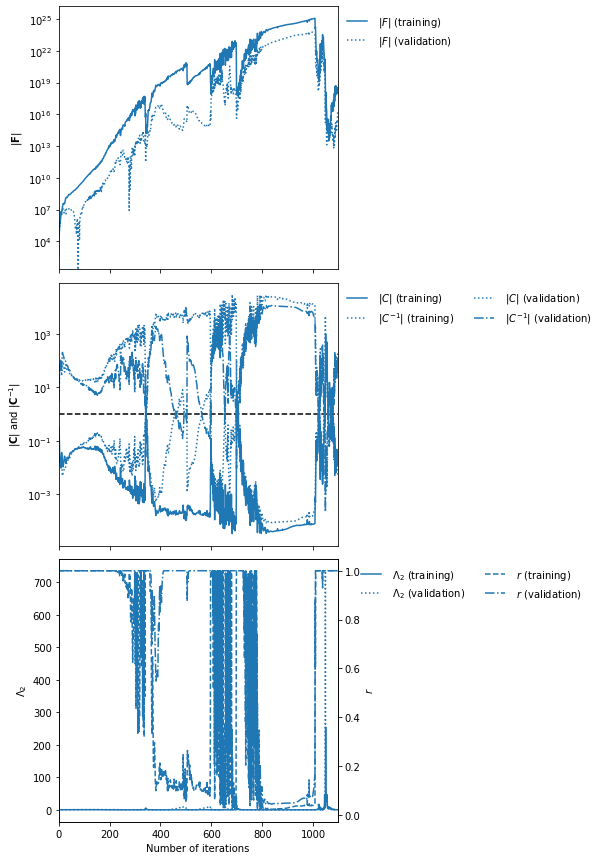

In [51]:
ax = IMNN.plot(expected_detF=None);
ax[0].set_yscale('log')

In [52]:
np.linalg.det(IMNN.F)

DeviceArray(6.148226e+23, dtype=float32)

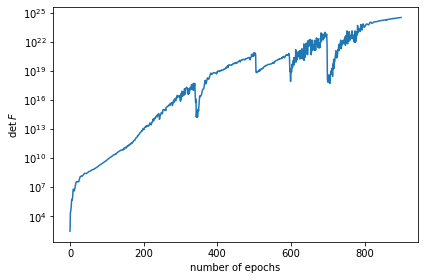

In [55]:
plt.plot(IMNN.history['detF'][:900])
#plt.plot(jnp.ones(len(IMNN.history['detF'][:]))*det_theoryF, c='k', linestyle='--', label='lognormal information')
#plt.ylim(1e-2, 1e8)
plt.ylabel(r'$\det F$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()